### 8-bit量化

如果量化没有取整这一步，那除一个再乘一个数就没变化了，有这个化整数才能INT8的全放指数位，范围是-127-127

In [ ]:
import numpy as np

# 量化是除量化步长、反量化是乘量化步长
def quantize(input_data, abs_max):
    # 计算量化步长
    quantize_step = abs_max / 127
    # 量化
    print('8bit化浮点:', input_data /quantize_step)
    
    quantized_data = np.round(input_data / quantize_step)
    
    print("8bit量化整数:", quantized_data)
    
    quantized_data = np.clip(quantized_data, -127, 127)
    return quantized_data.astype(np.uint8)

def dequantize(quantized_data, abs_max):
    quantize_step = abs_max / 127
    dequantized_data = quantized_data.astype(np.float32) * quantize_step
    return dequantized_data

input_data = np.array([0, 0.1, 0.5, 0.9, 1.3, 1.7, 2.0])
abs_max = np.max(input_data)
quantized_data = quantize(input_data, abs_max)
print('quantized_data:', quantized_data)
dequantized_data = dequantize(quantized_data, abs_max)
print('dequantized_data:', dequantized_data)


8bit化浮点: [  0.     6.35  31.75  57.15  82.55 107.95 127.  ]
8bit量化整数: [  0.   6.  32.  57.  83. 108. 127.]
quantized_data: [  0   6  32  57  83 108 127]
dequantized_data: [0.         0.09448819 0.50393701 0.8976378  1.30708661 1.7007874
 2.        ]


### 8bit表示

In [3]:
def print_binary(nums):
    for it in nums:
        binary_str = np.binary_repr(it, width=8)
        print(binary_str)

print('8bit量化二进制表示:', quantized_data)
print_binary(quantized_data)

8bit量化二进制表示: [  0   6  32  57  83 108 127]
00000000
00000110
00100000
00111001
01010011
01101100
01111111


### 4bit量化计算

INT4 量化：就是把所有待量化的浮点数，都映射到「16 个固定量化值」中的某一个；

简要说明, 当一个数字为0.8, 使用INT4量化, 则找到与之最近的0.8571，此时得到INT4序列数组index为2也就完成了0.8->量化成-> index 2(INT4 的index有16个数字)

总结：INT4/FP4 最近邻量化 = 把任意浮点数，通过「找最接近的固定值」的方式，映射到 0~15 的整数索引，用 4bit 存储，实现显存压缩，推理时再还原回数值。

In [ ]:
# 这个是NF4的计算

import torch
from scipy.stats import norm
# offset是一个概率值，约等于96.77%，对应标准正态分布的Z值约为2.0，因为norm.ppf(0.9677083) ≈ 2.0
offset = 0.9677083

print("----------------P step---------------------")

# step_pos：从offset（0.9677083）到0.5生成9个等差值，然后去掉最后一个元素（即不包含0.5）
step_pos = torch.linspace(offset, 0.5, 9)[:-1] 
step_neg = torch.linspace(offset, 0.5, 8)[:-1]

print("NF step 9: ",step_pos)
print("NF step 8: ",step_neg)

print("----------------norm---------------------")

v1 = norm.ppf(step_pos).tolist()
print("NF+:", [f'{num:.4f}' for num in v1])
v2 = [0]
v3 = (-norm.ppf(step_neg)).tolist()
print("NF-:", [f'{num:.4f}' for num in v3])

v = v1 + v2 + v3

print("----------------nf4 归一化---------------------")

values = torch.Tensor(v)
values = values.sort().values
values /= values.max()
print("NF4/max:", [f'{num:.4f}' for num in values])


----------------P step---------------------
NF step 9:  tensor([0.9677, 0.9092, 0.8508, 0.7923, 0.7339, 0.6754, 0.6169, 0.5585])
NF step 8:  tensor([0.9677, 0.9009, 0.8341, 0.7673, 0.7004, 0.6336, 0.5668])
----------------norm---------------------
NF+: ['1.8481', '1.3361', '1.0398', '0.8145', '0.6245', '0.4548', '0.2974', '0.1471']
NF-: ['-1.8481', '-1.2867', '-0.9704', '-0.7299', '-0.5257', '-0.3415', '-0.1683']
----------------nf4 归一化---------------------
NF4/max: ['-1.0000', '-0.6962', '-0.5251', '-0.3949', '-0.2844', '-0.1848', '-0.0911', '0.0000', '0.0796', '0.1609', '0.2461', '0.3379', '0.4407', '0.5626', '0.7230', '1.0000']


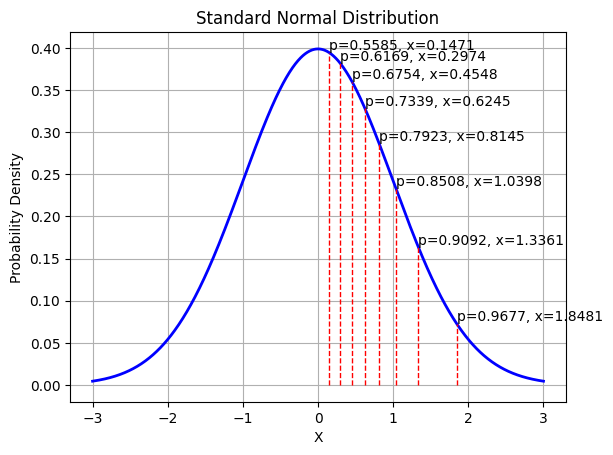

In [10]:
import matplotlib.pyplot as plt
x = np.linspace(-3, 3, 1000)
y = norm.pdf(x, 0, 1)  # 均值为0，标准差为1的正态分布
plt.plot(x, y, 'b-', linewidth=2)
prob_list = torch.linspace(offset, 0.5, 9)[:-1].tolist()
for prob in prob_list:
    x_prob = norm.ppf(prob, 0, 1)  # 根据概率计算对应的横坐标
    y_prob = norm.pdf(x_prob, 0, 1)  # 计算指定概率处的纵坐标
    plt.plot([x_prob, x_prob], [0, y_prob], 'r--', linewidth=1)  
    plt.text(x_prob, y_prob, f'p={prob:.4f}, x={x_prob:.4f}', ha='left', va='bottom') 
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.title('Standard Normal Distribution')
plt.grid(True)
plt.show()

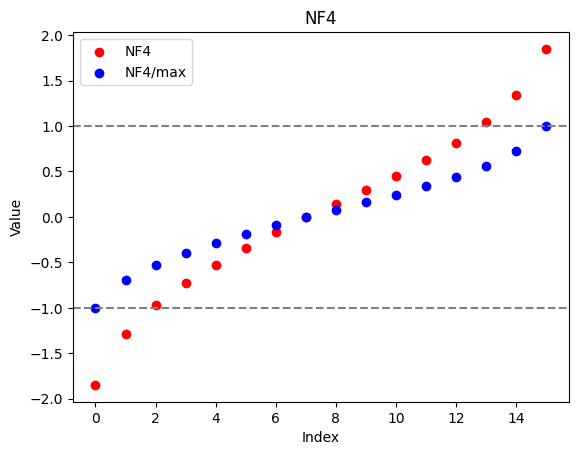

In [11]:
v_tensor = torch.Tensor(v)
v_sort = v_tensor.sort().values
plt.axhline(y=1, color='gray', linestyle='--', )
plt.axhline(y=-1, color='gray', linestyle='--', )
plt.scatter(range(len(v_sort)), v_sort, c='red', label='NF4')
plt.scatter(range(len(values)), values, c='blue', label='NF4/max')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('NF4')
plt.legend()
plt.show()